# Thermal Imaging-based Physiological and Affective computing (TIPA)
## TIPA Opensource project 

Created: August 2019 (very initial stage) <br>
Author(s): Dr. Youngjun Cho (Assistant Professor, Department of Computer Science, University College London, UCL) <br>

This project is to support the <a href="http://acii-conf.org/wp-content/uploads/2019/08/ACII2019_tutorial_programme-EDIT.pdf">ACII 2019</a>'s tutorial on Thermal Imaging-based Physiological and Affective computing <br>
<br>

Full source code: https://github.com/deepneuroscience/TIPA <br>
Example dataset: <a href="https://drive.google.com/open?id=1hn3VjwILNiJ0-nNKwR80Sb6zV3Vil26w">Link</a> <br>
Temporary TIPA opensource project website: http://youngjun.cho/TIPA<br>




## Key Reference

[1] Youngjun Cho and Nadia Bianchi-Berthouze. 2019. Physiological and Affective Computing through Thermal Imaging: A Survey. arXiv:1908.10307 [cs], http://arxiv.org/abs/1908.10307

### Further Technical References
[2] Cho, Y., Julier, S.J., Marquardt, N. and Bianchi-Berthouze, N., 2017. Robust tracking of respiratory rate in high-dynamic range scenes using mobile thermal imaging. Biomedical optics express, 8(10), pp.4480-4503. https://doi.org/10.1364/BOE.8.004480

[3] Cho, Y., Julier, S.J. and Bianchi-Berthouze, N., 2019. Instant Stress: Detection of Perceived Mental Stress Through Smartphone Photoplethysmography and Thermal Imaging. JMIR mental health, 6(4), p.e10140. https://doi.org/10.2196/10140

[4] Cho, Y., Bianchi-Berthouze, N. and Julier, S.J., 2017. DeepBreath: Deep learning of breathing patterns for automatic stress recognition using low-cost thermal imaging in unconstrained settings. In 2017 Seventh International Conference on Affective Computing and Intelligent Interaction (ACII) (pp. 456-463). IEEE. https://doi.org/10.1109/ACII.2017.8273639

[5] Cho, Y., Bianchi-Berthouze, N., Marquardt, N. and Julier, S.J., 2018. Deep Thermal Imaging: Proximate Material Type Recognition in the Wild through Deep Learning of Spatial Surface Temperature Patterns. In Proceedings of the 2018 CHI Conference on Human Factors in Computing Systems, ACM. https://doi.org/10.1145/3173574.3173576

Let's start!

## Basic tutorial

### 1. Import TIPA libraries

In [1]:
import sys
#sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
from platform import python_version
# sys.path.insert(0,'./TIPA_library/')

from TIPA_library.main.data_preparation import *
from TIPA_library.main.thermal_image_processing import *
from TIPA_library.utils import timshow as tim
from TIPA_library.utils import rvs


In [62]:
import cv2
print(cv2.__version__)

ROI_seq, t_video =thermal_tracker(thermal_matrix, 'optimal', 'MEDIANFLOW', False, False)

4.4.0


AttributeError: module 'cv2.cv2' has no attribute 'TrackerMedianFlow_create'

### 2. Loading a raw sequence of thermal 2d matrices
The TIPA project mainly uses the TIPA frame protocol below by default.

For FLIR ONE (SDK) users,
you can simply implement the code from the link below.
https://github.com/deepneuroscience/DeepThermalImaging/tree/master/example%20code%20for%20FLIR%20One%20sdk


<img src="https://github.com/deepneuroscience/TIPA/blob/master/figures/figure1.png?raw=true">
        Figure 1. TIPA (Thermal Imaging-based Physiological and Affective computing) Project Dataframe protocol

#### Example Dataset
We provide example data. <br><br>
Download this dataset - <a href="https://drive.google.com/open?id=1hn3VjwILNiJ0-nNKwR80Sb6zV3Vil26w">Link</a> <br>
Unzip, move them to a directory (./data) <br>
./data/example_data.dat<br>
./data/example_data_in_front_of_building.dat<br>

In [2]:
# The matrix size has to be known in advance. e.g.320 x 240
#data = data_preparation_TIPA_protocol('./data/example_data.dat',320,240)
data = data_preparation_TIPA_protocol('./data/example_data_in_front_of_building.dat',320,240)
#print(data.time_stamp)

                                                                                                                    

In [12]:
np.arange(0,2,0.1)
data.length

AttributeError: 'data_preparation_TIPA_protocol' object has no attribute 'length'

In [5]:
print(data.time_stamp)

[ 0.     0.137  0.243  0.372  0.505  0.62   0.728  0.837  0.941  1.054
  1.178  1.29   1.399  1.517  1.634  1.75   1.85   1.948  2.046  2.148
  2.247  2.377  2.489  2.605  2.723  2.831  2.946  3.065  3.171  3.281
  3.403  3.52   3.73   3.838  3.948  4.078  4.197  4.313  4.417  4.519
  4.627  4.729  4.833  4.938  5.057  5.168  5.268  5.37   5.47   5.573
  5.69   5.798  5.944  6.051  6.161  6.281  6.387  6.492  6.595  6.727
  6.833  6.937  7.058  7.164  7.279  7.388  7.511  7.641  7.756  7.881
  7.984  8.089  8.191  8.295  8.45   8.557  8.786  8.897  9.012  9.127
  9.248  9.39   9.526  9.639  9.745  9.868  9.984 10.092 10.212 10.324
 10.453 10.56  10.682 10.812 10.947 11.063 11.183 11.287 11.42  11.524
 11.627 11.76  11.876 11.984 12.101 12.233 12.342 12.459 12.591 12.7
 12.824 12.928 13.031 13.164 13.271 13.409 13.538 13.644 13.838 13.958
 14.082 14.214 14.326 14.435 14.565 14.67  14.773 14.876 14.999 15.103
 15.207 15.308 15.414 15.544 15.675 15.819 15.965 16.113 16.253 16.4
 16.557 16

For the ones using other thermal cameras,<br>
simply load raw thermal matrices with your known framerate<br>
(you may need to convert the ascii format, e.g. *.asc to a matrix.) <br>
contact youngjun[dot]cho[at]ucl.ac.uk for any quiries


In [50]:
#data = data_preparation_raw_matrix(matrix, framerate)


AttributeError: 'data_preparation_TIPA_protocol' object has no attribute 'shape'

### 3. Manual Inspection of the loaded thermal matrices
<br>

#### Tool 1: interactive_thermal_matrix_view <br>
simply, you can examine temperatures on your thermal image with your cursor.



<IPython.core.display.Javascript object>


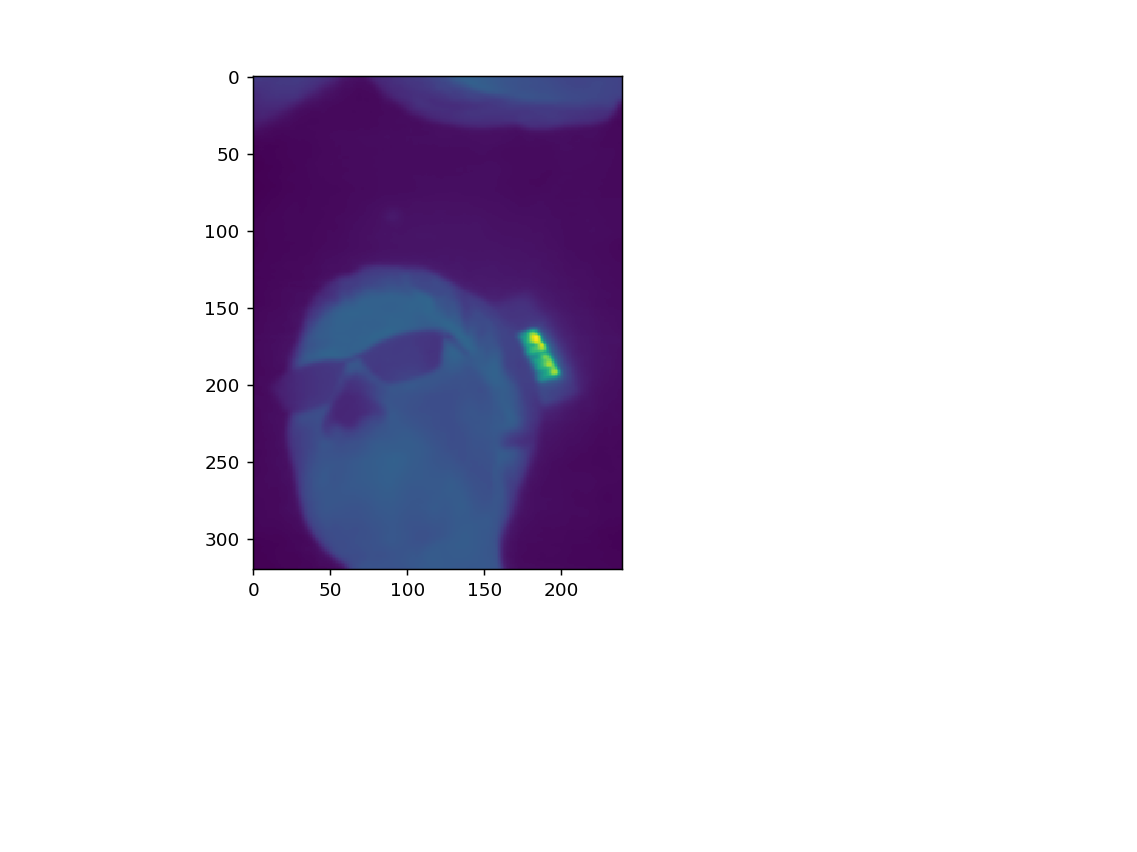

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

%matplotlib notebook
def update(fig):
    fig.canvas.draw()
    
def interactive_thermal_matrix_view(matrix):
    fig= plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.imshow(matrix)
    
    interact(update(fig))


frame_number = 1
interactive_thermal_matrix_view(data.thermal_matrix[:,:,frame_number])


#### Tool 2: Interactive ImShow Cond1 for multiple frames <br>
simply, you can change the value on the slider (frame_num). e.g. frame number = 100


In [4]:
from ipywidgets import interactive, FloatRangeSlider, Output, VBox
%matplotlib inline

interactive_plot = interactive(data.interactive_imshow_cond,  frame_number=(0, data.thermal_matrix.shape[2]-1))
output = interactive_plot.children[-1]
output.layout.height = '320px'
interactive_plot
# VBox([range_slider,interactive_plot])

interactive(children=(IntSlider(value=194, description='frame_number', max=389), Output(layout=Layout(height='…

#### Tool 3: Interactive ImShow Cond2 for multiple frames with a function to select your thermal range of interest <br>
in short, you can change the value on the slider (frame_num). e.g. frame number = 100 <br>
and you can adjust the thermal (temperature) range of interest <br>

In [5]:
from ipywidgets import interactive, FloatRangeSlider, Output, VBox, Layout
%matplotlib inline

# layout = Layout(width='500px')
range_slider = widgets.FloatRangeSlider(
    value=[0, +50],
    min=0., max=+60., step=0.1,
    description='thermal range of interest',
    readout_format='.1f',
#     layout=layout
)
# range_slider

interactive_plot = interactive(data.interactive_imshow_cond2,  frame_number=(0, data.thermal_matrix.shape[2]-1), thermal_range=range_slider)
output = interactive_plot.children[-1]
output.layout.height = '320px'
interactive_plot
# VBox([range_slider,interactive_plot])


interactive(children=(IntSlider(value=194, description='frame_number', max=389), FloatRangeSlider(value=(0.0, …

#### Tool 4: Interactive ImShow Cond 3
##### for multiple frames with the optimal quantization to automatically select your thermal range of interest <br>
in short, you can change the value on the slider (frame_num). e.g. frame number = 100 <br>
and this will automatically select your thermal (temperature) range of interest <br>
We will come back here again on the preprocessing section 
###### [Key reference]<br>
Cho, Y., Julier, S.J., Marquardt, N. and Bianchi-Berthouze, N., 2017. Robust tracking of respiratory rate in high-dynamic range scenes using mobile thermal imaging. Biomedical optics express, 8(10), pp.4480-4503. https://doi.org/10.1364/BOE.8.004480

In [6]:
from ipywidgets import interactive, FloatRangeSlider, Output, VBox, Layout
%matplotlib inline


interactive_plot = interactive(data.interactive_imshow_cond3,  frame_number=(0, data.thermal_matrix.shape[2]-1))
output = interactive_plot.children[-1]
output.layout.height = '320px'
interactive_plot
# VBox([range_slider,interactive_plot])


interactive(children=(IntSlider(value=194, description='frame_number', max=389), Output(layout=Layout(height='…

### 4. Computational Pipeline
Here, we focus on the case where an automatic ROI tracking method is used.
For the ROI selection,
a ROI can be chosen either manually or automatically. (here we select it manually)

<img src="https://github.com/deepneuroscience/TIPA/blob/master/figures/figure2.png?raw=true"> <br>
Figure 2. Computational pipeline that has been commonly applied to studies on thermal imaging-based physiological computing: this consists of three main steps, the ROI selection, automatic ROI tracking and spatial interpretation. a) with automatic ROI tracking, b) without automatic ROI tracking (in this case a head fixation mount is used)<br>
<br>
[Reference]
Youngjun Cho and Nadia Bianchi-Berthouze. 2019. Physiological and Affective Computing through Thermal Imaging: A Survey. arXiv:1908.10307 [cs], http://arxiv.org/abs/1908.10307

<br>



### 4.1. Preprocessing (Quantization)

#### [Two standard methods]
A) Non-optimal (linear) quantization <br>
Mapping temperatures to thermal images with a selected temperature range of interest, which is traditionally fixed from the first thermogram frame (e.g. 30°C to 40°C) <br>
<br>
B) Optimal quantization<br>
Mapping temperatures to thermal images adaptively against environmental temperature effects.<br>
<br>
Go back to Section 3 and compare Tool C with Tool D (optimal quantization is applied) <br>
<br>

###### [Key reference]
Cho, Y., Julier, S.J., Marquardt, N. and Bianchi-Berthouze, N., 2017. Robust tracking of respiratory rate in high-dynamic range scenes using mobile thermal imaging. Biomedical optics express, 8(10), pp.4480-4503. https://doi.org/10.1364/BOE.8.004480

<img src="https://github.com/deepneuroscience/TIPA/blob/master/figures/figure3.png?raw=true"> <br>
Figure 3. High thermal dynamic range scenes: fixed thermal range of interest is not suitable in preserving the morphological facial shape within varying ambient temperature: [top] examples of thermogram shots collected from a person walking outdoor (for 6 minutes), [bottom] temperature histograms<br>
<br>

#### 4.1.1. Non-optimal (linear) quantization

your fixed thermal range of interest is [30.000000, 40.000000]


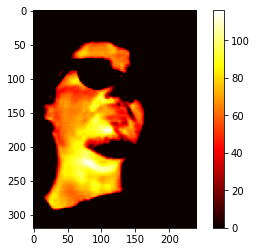

In [3]:
frame_number = 1

temp_mat = copy.deepcopy(data.thermal_matrix[:,:,frame_number])   ## Object should be deep copied. not mat = data.thermal_matrix
output = nonoptimal_quantization(temp_mat, 10, 40, True)

%matplotlib inline
tim.timshow(output)


#### 4.1.2. Optimal quantization

optimal thermal range is [24.259115, 33.570000]


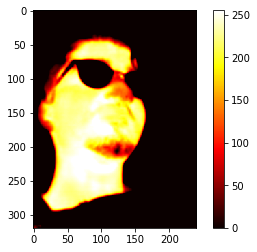

In [3]:
frame_number = 1
temp_mat = copy.deepcopy(data.thermal_matrix[:,:,frame_number])   ## Object should be deep copied. not mat = data.thermal_matrix
output = optimal_quantization(temp_mat, True)

%matplotlib inline
tim.timshow(output)

### 4.2. Automatic ROI Tracking 
#### This consists of 1) ROI selection, 2) Quantization, 3) ROI Tracking
Note: advanced trackers need to be implemented
here we are only using widely used motion tracking methods such as Median Flow, TLD etc.

In [11]:
print('1. Select your ROI and press Enter')
print('2. Press ESC to exit')
start_frame_number=1900
thermal_matrix=data.thermal_matrix[:,:,start_frame_number:-1]
#ROI_seq, t_video =thermal_tracker(thermal_matrix, 'optimal', 'MEDIANFLOW', False, False)
#ROI_seq, t_video =thermal_tracker(thermal_matrix, 'optimal', 'TLD', False, False)
ROI_seq, t_video =thermal_tracker(thermal_matrix, 'non-optimal', 'MEDIANFLOW', False, False, True, 0, 30)     
# ROI_seq, t_video =thermal_tracker(thermal_matrix) 
data.tracked_matrix=t_video

1. Select your ROI and press Enter
2. Press ESC to exit
frame: 20
frame: 40
frame: 60
frame: 80
frame: 100
frame: 120
frame: 140
frame: 160
frame: 180
frame: 200
frame: 220
frame: 240
frame: 260
frame: 280
frame: 300


In [51]:
temp_mat = copy.deepcopy(thermal_matrix[:,:,0])
optimal_quantization(temp_mat, True)

optimal thermal range is [25.478105, 33.750000]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [48]:
from ipywidgets import interactive, FloatRangeSlider, Output, VBox
%matplotlib inline

interactive_plot = interactive(data.interactive_imshow_cond4,  frame_number=(0, thermal_matrix.shape[2]-1))
output = interactive_plot.children[-1]
output.layout.height = '320px'
interactive_plot
VBox([range_slider,interactive_plot])


### 4.3. Spatial Interpretation

Here, we use a classical method only - averaging. <br>

In [8]:
# print(ROI_seq)
ft_vector = np.zeros((5,thermal_matrix.shape[2]))
for i in range(thermal_matrix.shape[2]) :
    ft_vector[1,i]= np.mean(thermal_matrix[int(ROI_seq[0,i]):int(ROI_seq[0,i]+ROI_seq[2,i]) ,int(ROI_seq[1,i]):int(ROI_seq[1,i]+ROI_seq[3,i]),i])

    

In [29]:
respiratory_signal=np.zeros(thermal_matrix.shape[2])
for i in range(thermal_matrix.shape[2]):

    temp=ft_vector[1,i]
    if(temp>=33.2):
        respiratory_signal[i]=32.4
    else:
        respiratory_signal[i]=32.0
    print(respiratory_signal[i])
respiratory_signal[1] =33
respiratory_signal[303]=32

32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.0
32.4
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.0
32.0
32.0
32.0
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.0
32.0
32.0
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.0
32.0
32.4
32.4
32.4
32.4
32.4
32.4
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.0
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.0
32.4
32.4
32.4
32.0
32.4
32.0
32.0
32.0
32.4
32.4
32.4
32.4
32.4
32.4
32.4
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.4
32.4
32.4
32.4


In [32]:
i

303

##### Plot the extracted signals

Now you have to prgramm your codes by yourself to refine your signals (e.g. bandpass filtering, frequency analysis, etc) <br>

In [9]:

from ipywidgets import interactive, FloatRangeSlider, Output, VBox, Layout, fixed
%matplotlib inline
start_frame_number=1000

layout = Layout(width='500px')
range_slider = widgets.FloatRangeSlider(
    value=[data.time_stamp[start_frame_number],data.time_stamp[-1]],
    min=data.time_stamp[start_frame_number], max= data.time_stamp[-1], step=1,
    description='range',
    readout_format='.1f',
    layout=layout
)
# range_slider

def interactive_timeplot(time, signal, fig_w, range_bar):
    fig = plt.gcf()
    yourDPI = fig.get_dpi()

#     plt.figure(figsize=(fig_w/yourDPI,(fig_w/yourDPI)/3))
    plt.plot(time, signal)
    plt.axis([range_bar[0], range_bar[1],min(signal), max(signal)])
#     plt.axis([time[int(range_bar[0])], time[int(range_bar[1])],min(signal[int(range_bar[0]):int(range_bar[1])]), max(signal[int(range_bar[0]):int(range_bar[1])])])
#                          min(signal[range_bar[0]:range_bar[1]]), max(signal[range_bar[0]:range_bar[1]])]
#     plt.show()
    
m_interactive_timeplot = interactive(interactive_timeplot, time= fixed(data.time_stamp[start_frame_number:-1]), signal=fixed(ft_vector[1,:]), fig_w=fixed(500), range_bar=range_slider)
#m_interactive_timeplot = interactive(interactive_timeplot, time= fixed(data.time_stamp[start_frame_number:-1]), signal=fixed(respiratory_signal), fig_w=fixed(500), range_bar=range_slider)
m_interactive_timeplot
#plt.plot(range(0,9),respiratory_signal)

interactive(children=(FloatRangeSlider(value=(114.304, 252.035), description='range', layout=Layout(width='500…

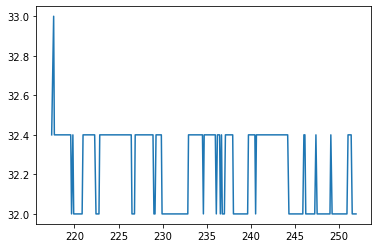

In [30]:
plt.plot((data.time_stamp[start_frame_number:-1]),(respiratory_signal))

In [19]:
data.time_stamp[start_frame_number:-1]

array([217.418, 217.643, 217.721, 217.798, 217.875, 217.97 , 218.085,
       218.203, 218.335, 218.464, 218.568, 218.652, 218.802, 218.878,
       219.024, 219.117, 219.265, 219.355, 219.451, 219.579, 219.672,
       219.824, 219.916, 220.015, 220.164, 220.265, 220.372, 220.488,
       220.638, 220.748, 220.872, 220.976, 221.062, 221.17 , 221.306,
       221.396, 221.566, 221.672, 221.773, 221.9  , 222.012, 222.088,
       222.189, 222.294, 222.445, 222.531, 222.701, 222.783, 222.87 ,
       222.996, 223.136, 223.229, 223.347, 223.473, 223.553, 223.666,
       223.782, 223.897, 224.013, 224.16 , 224.237, 224.35 , 224.466,
       224.616, 224.724, 224.814, 224.918, 225.041, 225.151, 225.263,
       225.369, 225.482, 225.629, 225.754, 225.836, 225.965, 226.067,
       226.221, 226.302, 226.442, 226.525, 226.646, 226.811, 226.891,
       226.979, 227.09 , 227.223, 227.315, 227.43 , 227.563, 227.844,
       227.924, 228.004, 228.111, 228.188, 228.267, 228.347, 228.451,
       228.569, 228.

In [20]:
ft_vector[1,:]

array([32.50894309, 32.38841094, 32.68250554, 32.42992609, 32.78793052,
       32.75076866, 32.76865484, 32.99402069, 32.86614191, 32.93055432,
       32.98013304, 33.03198078, 33.02190687, 32.89558019, 32.93101996,
       32.94983001, 32.8622912 , 32.86814486, 32.73473023, 32.65643755,
       32.54751663, 32.51657797, 32.22949741, 32.15744272, 32.14635625,
       32.06144863, 31.99025868, 32.03609756, 32.49656319, 32.70470067,
       32.84749446, 32.99311899, 33.03982262, 33.03708795, 33.11717664,
       33.1467997 , 33.12334812, 33.11441242, 32.93218773, 32.96644494,
       32.88325942, 32.78107908, 32.52203991, 32.47420547, 32.50369549,
       32.49424242, 32.31054693, 32.88868441, 32.94392461, 32.83507761,
       32.92400591, 32.93572801, 33.11716186, 33.17150776, 33.08127864,
       32.96836659, 32.82209904, 32.55219512, 32.73417591, 32.63720621,
       32.82981523, 32.8181966 , 32.87420547, 32.96144863, 33.09886179,
       33.14064302, 33.13540281, 33.1130303 , 33.1166371 , 33.09

In [17]:
data.time_stamp[start_frame_number:-1]

array([217.418, 217.643, 217.721, 217.798, 217.875, 217.97 , 218.085,
       218.203, 218.335, 218.464, 218.568, 218.652, 218.802, 218.878,
       219.024, 219.117, 219.265, 219.355, 219.451, 219.579, 219.672,
       219.824, 219.916, 220.015, 220.164, 220.265, 220.372, 220.488,
       220.638, 220.748, 220.872, 220.976, 221.062, 221.17 , 221.306,
       221.396, 221.566, 221.672, 221.773, 221.9  , 222.012, 222.088,
       222.189, 222.294, 222.445, 222.531, 222.701, 222.783, 222.87 ,
       222.996, 223.136, 223.229, 223.347, 223.473, 223.553, 223.666,
       223.782, 223.897, 224.013, 224.16 , 224.237, 224.35 , 224.466,
       224.616, 224.724, 224.814, 224.918, 225.041, 225.151, 225.263,
       225.369, 225.482, 225.629, 225.754, 225.836, 225.965, 226.067,
       226.221, 226.302, 226.442, 226.525, 226.646, 226.811, 226.891,
       226.979, 227.09 , 227.223, 227.315, 227.43 , 227.563, 227.844,
       227.924, 228.004, 228.111, 228.188, 228.267, 228.347, 228.451,
       228.569, 228.

close your extra opencv window

In [7]:
cv2.destroyAllWindows()

Note: currently working on codes for the spectrogram analysis
TIPA_library.utils: overlap_windows, overlap_matrix, gausswin, compute_frequency_grid, rvs
if your targeted signature is about respiratory or cardiac pulse, then you could use this code (respiration variability spectrogram) later
<br>
A key reference for this:
Cho, Y., Bianchi-Berthouze, N. and Julier, S.J., 2017. DeepBreath: Deep learning of breathing patterns for automatic stress recognition using low-cost thermal imaging in unconstrained settings. In 2017 Seventh International Conference on Affective Computing and Intelligent Interaction (ACII) (pp. 456-463). IEEE. https://doi.org/10.1109/ACII.2017.8273639 <br>

<br>
you need to use your own data as the given samples are with non-fixed sampling rates.<br>
rvs_output= rvs.rvs(8, ft_vector) (incomplete)


<br>
### Lastly, we warmly welcome potential contributors!

In [8]:
import numpy as np
import cv2

cap = cv2.VideoCapture('y2mate.com - Thermal Body Temp Measurement Solution - Dahua_1080p.mp4')

while(cap.isOpened()):
    ret, frame = cap.read()
    print(frame)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    cv2.imshow('frame',gray)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[29 29 29]
  [29 29 29]
  [29 29 29]
  ...
  [11 11 11]
  [11 11 11]
  [11 11 11]]

 [[29 29 29]
  [29 29 29]
  [29 29 29]
  ...
  [11 11 11]
  [11 11 11]
  [11 11 11]]

 [[29 29 29]
  [29 29 29]
  [29 29 29]
  ...
  [11 11 11]
  [11 11 11]
  [11 11 11]]

 ...

 [[27 27 27]
  [27 27 27]
  [27 27 27]
  ...
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[27 27 27]
  [27 27 27]
  [27 27 27]
  ...
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[27 27 27]
  [27 27 27]
  [27 27 27]
  ...
  [10 10 10]
  [10 10 10]
  [10 10 10]]]
[[[50 47 48]
  [50 47 48]
  [50 47 48]
  ...
  [24 21 22]
  [24 21 22]
  [24 21 22]]

 [[50 47 48]
  [50 47 48]
  [50 47 48]
  ...
  [22 19 20]
  [22 19 20]
  [22 19 20]]

 [[50 47 48]
  [50 47 48]
  [50 47 48]
  ...
  [22 19 20]
  [22 19 20]
  [22 19 20]]

 ...

 [[49 46 45]
  [49 46 45]
  [49 46 45]
  ...
  [16 16 16]
  [16 16 16]
  [16 16 16]]

 [[49 46 45]
  [49 46 45]
  [49 46 45]
  ...
  [16 16 16]
  [16 16 16]
  [16 16 16]]

 [[49 46 45]
  [49 46 45]
  [49 46 45]
  .

[[[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 70  65  64]
  [ 70  65  64]
  [ 70  65  64]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 69  64  63]
  [ 69  64  63]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 70  65  64]
  [ 70  65  64]]

 ...

 [[157 153 149]
  [157 153 149]
  [157 153 149]
  ...
  [ 57  54  53]
  [ 57  54  53]
  [ 57  54  53]]

 [[157 153 149]
  [157 153 149]
  [157 153 149]
  ...
  [ 57  54  53]
  [ 57  54  53]
  [ 57  54  53]]

 [[157 153 149]
  [157 153 149]
  [157 153 149]
  ...
  [ 57  54  53]
  [ 57  54  53]
  [ 57  54  53]]]
[[[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 70  65  64]
  [ 70  65  64]
  [ 70  65  64]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 69  64  63]
  [ 69  64  63]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 70  65  64]
  [ 70  65  64]]

 ...

 [[157 153 149]
  [157 153 149]
  [157 153 149]
  ..

[[[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 70  65  64]
  [ 70  65  64]
  [ 70  65  64]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 69  64  63]
  [ 69  64  63]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 70  65  64]
  [ 70  65  64]]

 ...

 [[157 153 149]
  [157 153 149]
  [157 153 149]
  ...
  [ 55  52  51]
  [ 54  51  50]
  [ 54  51  50]]

 [[157 153 149]
  [157 153 149]
  [157 153 149]
  ...
  [ 55  52  51]
  [ 54  51  50]
  [ 54  51  50]]

 [[157 153 149]
  [157 153 149]
  [157 153 149]
  ...
  [ 55  52  51]
  [ 54  51  50]
  [ 54  51  50]]]
[[[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 70  65  64]
  [ 70  65  64]
  [ 70  65  64]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 69  64  63]
  [ 69  64  63]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 70  65  64]
  [ 70  65  64]]

 ...

 [[157 153 149]
  [157 153 149]
  [157 153 149]
  ..

[[[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 70  65  64]
  [ 70  65  64]
  [ 70  65  64]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 69  64  63]
  [ 69  64  63]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 70  65  64]
  [ 70  65  64]]

 ...

 [[157 153 149]
  [157 153 149]
  [157 153 149]
  ...
  [ 55  52  51]
  [ 54  51  50]
  [ 54  51  50]]

 [[157 153 149]
  [157 153 149]
  [157 153 149]
  ...
  [ 55  52  51]
  [ 54  51  50]
  [ 54  51  50]]

 [[157 153 149]
  [157 153 149]
  [157 153 149]
  ...
  [ 55  52  51]
  [ 54  51  50]
  [ 54  51  50]]]
[[[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 70  65  64]
  [ 70  65  64]
  [ 70  65  64]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 69  64  63]
  [ 69  64  63]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 70  65  64]
  [ 70  65  64]]

 ...

 [[157 153 149]
  [157 153 149]
  [157 153 149]
  ..

[[[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 70  65  64]
  [ 70  65  64]
  [ 70  65  64]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 69  64  63]
  [ 69  64  63]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 70  65  64]
  [ 70  65  64]]

 ...

 [[160 156 152]
  [160 156 152]
  [160 156 152]
  ...
  [ 55  52  51]
  [ 54  51  50]
  [ 54  51  50]]

 [[160 156 152]
  [160 156 152]
  [160 156 152]
  ...
  [ 55  52  51]
  [ 54  51  50]
  [ 54  51  50]]

 [[160 156 152]
  [160 156 152]
  [160 156 152]
  ...
  [ 55  52  51]
  [ 54  51  50]
  [ 54  51  50]]]
[[[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 70  65  64]
  [ 70  65  64]
  [ 70  65  64]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 69  64  63]
  [ 69  64  63]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 70  65  64]
  [ 70  65  64]]

 ...

 [[160 156 152]
  [160 156 152]
  [160 156 152]
  ..

[[[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 70  65  64]
  [ 70  65  64]
  [ 70  65  64]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 69  64  63]
  [ 69  64  63]]

 [[163 155 155]
  [163 155 155]
  [163 155 155]
  ...
  [ 69  64  63]
  [ 70  65  64]
  [ 70  65  64]]

 ...

 [[160 156 152]
  [160 156 152]
  [160 156 152]
  ...
  [ 55  52  51]
  [ 54  51  50]
  [ 54  51  50]]

 [[160 156 152]
  [160 156 152]
  [160 156 152]
  ...
  [ 55  52  51]
  [ 54  51  50]
  [ 54  51  50]]

 [[160 156 152]
  [160 156 152]
  [160 156 152]
  ...
  [ 55  52  51]
  [ 54  51  50]
  [ 54  51  50]]]
[[[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 70  65  64]
  [ 70  65  64]
  [ 70  65  64]]

 [[162 154 154]
  [162 154 154]
  [162 154 154]
  ...
  [ 69  64  63]
  [ 69  64  63]
  [ 69  64  63]]

 [[163 155 155]
  [163 155 155]
  [163 155 155]
  ...
  [ 69  64  63]
  [ 70  65  64]
  [ 70  65  64]]

 ...

 [[160 156 152]
  [160 156 152]
  [160 156 152]
  ..

[[[164 156 156]
  [164 156 156]
  [164 156 156]
  ...
  [ 70  65  64]
  [ 70  65  64]
  [ 70  65  64]]

 [[164 156 156]
  [164 156 156]
  [164 156 156]
  ...
  [ 69  64  63]
  [ 69  64  63]
  [ 69  64  63]]

 [[164 156 156]
  [164 156 156]
  [164 156 156]
  ...
  [ 69  64  63]
  [ 70  65  64]
  [ 70  65  64]]

 ...

 [[160 156 152]
  [160 156 152]
  [161 157 153]
  ...
  [ 55  52  51]
  [ 54  51  50]
  [ 54  51  50]]

 [[160 156 152]
  [160 156 152]
  [161 157 153]
  ...
  [ 55  52  51]
  [ 54  51  50]
  [ 54  51  50]]

 [[160 156 152]
  [160 156 152]
  [161 157 153]
  ...
  [ 55  52  51]
  [ 54  51  50]
  [ 54  51  50]]]
[[[164 156 156]
  [164 156 156]
  [164 156 156]
  ...
  [ 70  65  64]
  [ 70  65  64]
  [ 70  65  64]]

 [[164 156 156]
  [164 156 156]
  [164 156 156]
  ...
  [ 69  64  63]
  [ 69  64  63]
  [ 69  64  63]]

 [[164 156 156]
  [164 156 156]
  [164 156 156]
  ...
  [ 69  64  63]
  [ 70  65  64]
  [ 70  65  64]]

 ...

 [[160 156 152]
  [160 156 152]
  [161 157 153]
  ..

[[[169 161 161]
  [169 161 161]
  [169 161 161]
  ...
  [ 76  71  70]
  [ 77  72  71]
  [ 77  72  71]]

 [[169 161 161]
  [169 161 161]
  [169 161 161]
  ...
  [ 76  71  70]
  [ 77  72  71]
  [ 77  72  71]]

 [[169 161 161]
  [169 161 161]
  [169 161 161]
  ...
  [ 76  71  70]
  [ 76  71  70]
  [ 77  72  71]]

 ...

 [[167 162 161]
  [167 162 161]
  [167 162 161]
  ...
  [ 55  55  53]
  [ 55  55  53]
  [ 55  55  53]]

 [[167 162 161]
  [167 162 161]
  [167 162 161]
  ...
  [ 55  55  53]
  [ 55  55  53]
  [ 55  55  53]]

 [[167 162 161]
  [167 162 161]
  [167 162 161]
  ...
  [ 55  55  53]
  [ 55  55  53]
  [ 55  55  53]]]
[[[169 161 161]
  [169 161 161]
  [169 161 161]
  ...
  [ 76  71  70]
  [ 77  72  71]
  [ 77  72  71]]

 [[169 161 161]
  [169 161 161]
  [169 161 161]
  ...
  [ 76  71  70]
  [ 77  72  71]
  [ 77  72  71]]

 [[169 161 161]
  [169 161 161]
  [169 161 161]
  ...
  [ 76  71  70]
  [ 76  71  70]
  [ 77  72  71]]

 ...

 [[167 162 161]
  [167 162 161]
  [167 162 161]
  ..

[[[170 162 162]
  [170 162 162]
  [170 162 162]
  ...
  [ 77  72  71]
  [ 78  73  72]
  [ 78  73  72]]

 [[170 162 162]
  [170 162 162]
  [170 162 162]
  ...
  [ 77  72  71]
  [ 78  73  72]
  [ 78  73  72]]

 [[168 163 162]
  [168 163 162]
  [168 163 162]
  ...
  [ 77  72  71]
  [ 77  72  71]
  [ 78  73  72]]

 ...

 [[167 162 161]
  [167 162 161]
  [167 162 161]
  ...
  [ 55  55  53]
  [ 55  55  53]
  [ 55  55  53]]

 [[167 162 161]
  [167 162 161]
  [167 162 161]
  ...
  [ 55  55  53]
  [ 55  55  53]
  [ 55  55  53]]

 [[167 162 161]
  [167 162 161]
  [167 162 161]
  ...
  [ 55  55  53]
  [ 55  55  53]
  [ 55  55  53]]]
[[[170 162 162]
  [170 162 162]
  [170 162 162]
  ...
  [ 77  72  71]
  [ 78  73  72]
  [ 78  73  72]]

 [[170 162 162]
  [170 162 162]
  [170 162 162]
  ...
  [ 77  72  71]
  [ 78  73  72]
  [ 78  73  72]]

 [[168 163 162]
  [168 163 162]
  [168 163 162]
  ...
  [ 77  72  71]
  [ 77  72  71]
  [ 78  73  72]]

 ...

 [[167 162 161]
  [167 162 161]
  [167 162 161]
  ..

[[[175 165 165]
  [175 165 165]
  [175 165 165]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[175 165 165]
  [175 165 165]
  [175 165 165]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[175 165 165]
  [175 165 165]
  [175 165 165]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[171 166 165]
  [171 166 165]
  [171 166 165]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[171 166 165]
  [171 166 165]
  [171 166 165]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[171 166 165]
  [171 166 165]
  [171 166 165]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[175 165 165]
  [175 165 165]
  [175 165 165]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[175 165 165]
  [175 165 165]
  [175 165 165]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[175 165 165]
  [175 165 165]
  [175 165 165]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[171 166 165]
  [171 166 165]
  [171 166 165]
  ..

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[3 3 3]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[5 2 3]
  [3 0 1]
  [3 0 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[5 2 3]
  [3 0 1]
  [3 0 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[3 3 3]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[5 2 3]
  [3 0 1]
  [3 0 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[5 2 3]
  [3 0 1]
  [3 0 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[3 3 3]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[5 2 3]
  [3 0 1]
  [3 0 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[5 2 3]
  [3 0 1]
  [3 0 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[3 3 3]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[5 2 3]
  [3 0 1]
  [3 0 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[5 2 3]
  [3 0 1]
  [3 0 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[3 3 3]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[5 2 3]
  [3 0 1]
  [3 0 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[5 2 3]
  [3 0 1]
  [3 0 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[3 3 3]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[5 2 3]
  [3 0 1]
  [3 0 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[5 2 3]
  [3 0 1]
  [3 0 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [ ]:
cv2.destroyAllWindows()

In [2]:
import cv2
import numpy as np

cap = cv2.VideoCapture('y2mate.com - Thermal Body Temp Measurement Solution - Dahua_1080p.mp4')
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

buf = np.empty((100, frameHeight, frameWidth, 3), np.dtype('uint8'))

fc = 0
ret = True

while (fc < 100  and ret):
    ret, buf[fc] = cap.read()
    fc += 1

cap.release()

#cv2.namedWindow('frame 10')
#cv2.imshow('frame 10', buf[9])

#cv2.waitKey(0)

In [3]:
buf


array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0,

In [11]:
import cv2
cap = cv2.VideoCapture('')
cv2.namedWindow('frame',cv2.WINDOW_NORMAL)
cv2.resizeWindow('frame', 800,800)

while(cap.isOpened()):
    ret, frame = cap.read('y2mate.com - Thermal Body Temp Measurement Solution - Dahua_1080p.mp4')
    #np_frame = cv2.imread('video', frame) # does not work
    #np_frame = np.asarray(cv2.GetMat(frame)) # does not work
    #print(np_frame.shape)
    #print(frame.shape)y2mate.com - Thermal Body Temp Measurement Solution - Dahua_1080p.mp4

    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [ ]:
cv2.destroyAllWindows()

In [ ]:
data = data_preparation_raw_matrix(frame, 25)
data

In [44]:
data.time_stamp

array([0.  , 0.04, 0.08])

In [43]:
frame_number = 
temp_mat = copy.deepcopy(data.thermal_matrix[:,:,frame_number])   ## Object should be deep copied. not mat = data.thermal_matrix
output = optimal_quantization(temp_mat, True)

%matplotlib inline
tim.timshow(output)

IndexError: index 3303 is out of bounds for axis 2 with size 3

In [38]:
print('1. Select your ROI and press Enter')
print('2. Press ESC to exit')
start_frame_number=1
thermal_matrix=data.thermal_matrix[:,:,start_frame_number:-1]
ROI_seq, t_video =thermal_tracker(thermal_matrix, 'optimal', 'MEDIANFLOW', False, False)
#ROI_seq, t_video =thermal_tracker(thermal_matrix, 'optimal', 'TLD', False, False)
#ROI_seq, t_video =thermal_tracker(thermal_matrix, 'non-optimal', 'MEDIANFLOW', False, False, True, 0, 30)     
# ROI_seq, t_video =thermal_tracker(thermal_matrix) 
data.tracked_matrix=t_video

1. Select your ROI and press Enter
2. Press ESC to exit


In [5]:
# import the necessary packages
#from ..convenience import is_cv3
import cv2
def count_frames(path, override=False):
    # grab a pointer to the video file and initialize the total
    # number of frames read
    video = cv2.VideoCapture(path)
    total = 0
    # if the override flag is passed in, revert to the manual
    # method of counting frames
    if override:
        total = count_frames_manual(video)
    # otherwise, let's try the fast way first
    else:
        # lets try to determine the number of frames in a video
        # via video properties; this method can be very buggy
        # and might throw an error based on your OpenCV version
        # or may fail entirely based on your which video codecs
        # you have installed
        try:

            total = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        # uh-oh, we got an error -- revert to counting manually
        except:
            total = count_frames_manual(video)
    # release the video file pointer
    video.release()
    # return the total number of frames in the video
    return total

In [6]:
total=count_frames('y2mate.com - Thermal Body Temp Measurement Solution - Dahua_1080p.mp4',False)
total

3303

In [3]:
import cv2
cap = cv2.VideoCapture('y2mate.com - Thermal Body Temp Measurement Solution - Dahua_1080p.mp4')
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS)

In [4]:
fps

25.0

In [27]:
import numpy as np
import cv2
import scipy
from matplotlib import pyplot as plt
from PIL import Image
from collections import Counter
blur_radius = 1.0
threshold = 50
video = cv2.VideoCapture('y2mate.com - Thermal Body Temp Measurement Solution - Dahua_1080p.mp4')
ret, frame = video.read()



In [28]:
frame

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)